# The Catering Problem

## Motivation

A catering company to cook $n$ dishes, but has only one available oven.
    At most a single dish can be inside the oven at one time.    
    Each dish $i$ has its earliest time when it can be put into the oven $r_i$ (since it needs to be prepared before it is put into the oven), the latest time it should be taken from the oven $d_i$ (since the customers do not want to wait too long), and the time it needs to stay in the oven $p_i$.
    The goal is to find the vector of times $\mathbf{s} = (s_0, \dots, s_{n-1})$ (denoting the times when each dish is put into the oven) such that the finish time of the last dish is minimal.
    
## Input

You are given the following:
* number of dished $n$
* parameters $r_i$, $d_i$ and $p_i$ for each dish $i$

For the testing purposes, you can experiment with the following instance:

In [1]:
n = 5
params = {
    0: {'r': 20, 'd': 45, 'p': 15},
    1: {'r':  4, 'd': 30, 'p': 19},
    2: {'r':  5, 'd': 80, 'p': 20},
    3: {'r': 17, 'd': 70, 'p':  8},
    4: {'r': 27, 'd': 66, 'p':  7}
}

# Note: parameter d_1 can be obtained by params[1]["d"]

## Output

You are expected to find the vector $\mathbf{s} = (s_0, \dots, s_{n-1})$ denoting the times when each dish should be put into the oven.

The optimal solution vector for the given instance is $\mathbf{s} = (23, 4, 53, 38, 46)$.

## Exercise

Your task is to formulate the ILP model of the catering problem, solve it, and extract the vector $\mathbf{s}$. The example solution follows:

In [2]:
import gurobipy as grb  # import Gurobi module

# model -----------------------------------------------------
model = grb.Model()

# - ADD VARIABLES
# variable s_i represents the time when the dish i is put into the oven
s = model.addVars(n, vtype=grb.GRB.CONTINUOUS, lb=0, name="s")
x = {}
# the binary variable x_ij represents the decision whether dish i is cooked before dish j or not
for i in range(n):
    for j in range(i):
        x[i, j] = model.addVar(vtype=grb.GRB.BINARY, name="x")

# Cmax models the objective (the finish time of the last dish)
Cmax = model.addVar(vtype=grb.GRB.CONTINUOUS, name="Cmax")

# - ADD CONSTRAINTS
for i in range(n):
    # link s_i with Cmax
    model.addConstr(s[i] + params[i]['p'] <= Cmax)
    # link s_i with r_i and d_i
    model.addConstr(s[i] >= params[i]['r'])
    model.addConstr(s[i] + params[i]['p'] <= params[i]['d'])

# initialize the value of 'big M'
M = sum([params[i]['p'] + params[i]['r'] for i in range(n)])

for i in range(n):
    for j in range(i):
        # forbid the overlaps between two jobs, i.e., link variables x_ij with s_i and s_j by 'big M' trick        
        model.addConstr(s[i] + params[i]['p'] <= s[j] + M*(1-x[i, j]))
        model.addConstr(s[j] + params[j]['p'] <= s[i] + M*x[i, j])

# - SET OBJECTIVE
# minimize Cmax
model.setObjective(Cmax, grb.GRB.MINIMIZE)

# call the solver -------------------------------------------
model.optimize()

# print the solution ----------------------------------------
print('\nSOLUTION:')
for i in range(n):
    # do not forget to extract the solution properly by rounding and casting the result to int
    # there might be cases, when the Gurobi solver has, e.g., 3.99999999 instead of 4 because of the numerics errors
    print('s_{} = {}'.format(i, int(round(s[i].x))))  

Academic license - for non-commercial use only
Optimize a model with 35 rows, 16 columns and 80 nonzeros
Variable types: 6 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 1e+02]
Presolve removed 31 rows and 12 columns
Presolve time: 0.00s
Presolved: 4 rows, 4 columns, 10 nonzeros
Variable types: 3 continuous, 1 integer (1 binary)

Root relaxation: objective 7.300000e+01, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   73.00000    0    1          -   73.00000      -     -    0s
H    0     0                      73.0000000   73.00000  0.00%     -    0s

Explored 1 nodes (1 simplex iterations) in 0.01 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 73 

Optimal solution found (toler

## Solution visualization

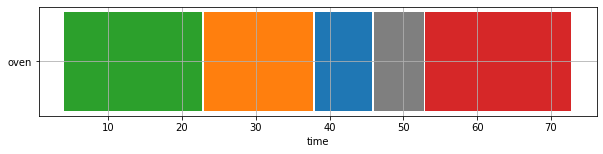

In [3]:
import matplotlib.pyplot as plt 

def plot_solution(s, p):
    """
    s: solution vector
    p: processing times
    """
    fig = plt.figure(figsize=(10,2))
    ax = plt.gca()
    ax.set_xlabel('time')     
    ax.grid(True) 
    ax.set_yticks([2.5])
    ax.set_yticklabels(["oven"]) 
    eps = 0.25  # just to show spaces between the dishes
    ax.broken_barh([(s[i], p[i]-eps) for i in range(len(s))], (0, 5), 
                   facecolors=('tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:gray'))

plot_solution([s[i].x for i in range(n)], [params[i]["p"] for i in range(n)])